In [299]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits

%matplotlib widget

figsize=(7,3)

## Directly calculate diffraction pattern by integrating

In [300]:
@njit(parallel=True)
def circ_mask(image_w, image_h, N_side, center, radius):
    x_res = image_w / N_side
    y_res = image_h / N_side
    src = np.ones((N_side, N_side))
    for i in prange(N_side):
        for j in prange(N_side):
            if np.sqrt((i * x_res - center[0])**2 + (j * y_res - center[1])**2) > radius:
                src[i][j] = 0
    return src


def gaussian_mask(image_w, image_h, N_side, center, fwhm):
    from scipy.stats import multivariate_normal
    x_res = image_w / N_side
    y_res = image_h / N_side
    xs = np.linspace(0, image_w, N_side)
    ys = np.linspace(0, image_h, N_side)
    xx, yy = np.meshgrid(xs, ys)
    ret = multivariate_normal([center[0], center[1]], [[fwhm / 2.355, 0], [0, fwhm / 2.355]])
    pos = np.empty(xx.shape + (2,))
    pos[:, :, 0] = xx
    pos[:, :, 1] = yy
    src = ret.pdf(pos)
    src /= src.max()
    return src

z/Fraunhofer: 0.00625
px per lambda: 0.0032


Text(0.5, 1.0, 'Image')

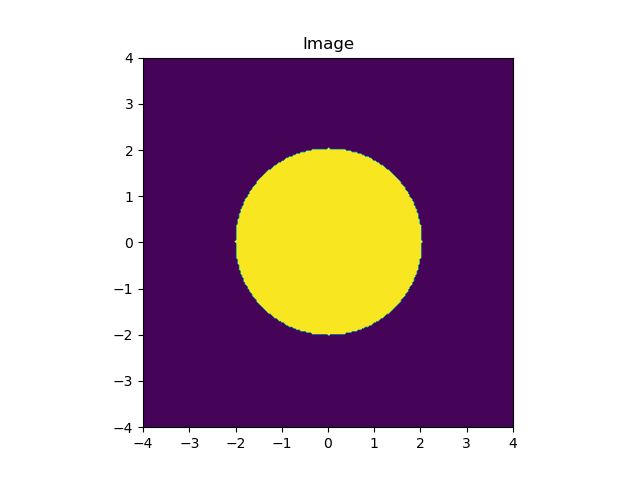

In [301]:
# define the source image
width_m = 8
height_m = width_m
center_m = np.array([width_m / 2., height_m / 2.])
radius_m = 2
N = 256
m_per_px = width_m / N

# define the propagation constants
lambd = 1e-4
z = 5e2

fraunhofer_dist = 2. * radius_m ** 2. / lambd
print('z/Fraunhofer:', z / fraunhofer_dist)

print('px per lambda:', lambd / m_per_px)

xs = np.linspace(-width_m / 2, width_m / 2, N)
ys = np.linspace(-height_m / 2, height_m / 2, N)
xx, yy = np.meshgrid(xs, ys)
img = circ_mask(width_m, height_m, N, center_m, radius_m)
# img = gaussian_mask(width_m, height_m, N, center_m, radius_m)

fig, ax = plt.subplots()
ax.contourf(xx, yy, img, levels=50, vmin=0, vmax=1)
ax.set_aspect('equal')
ax.set_title('Image')

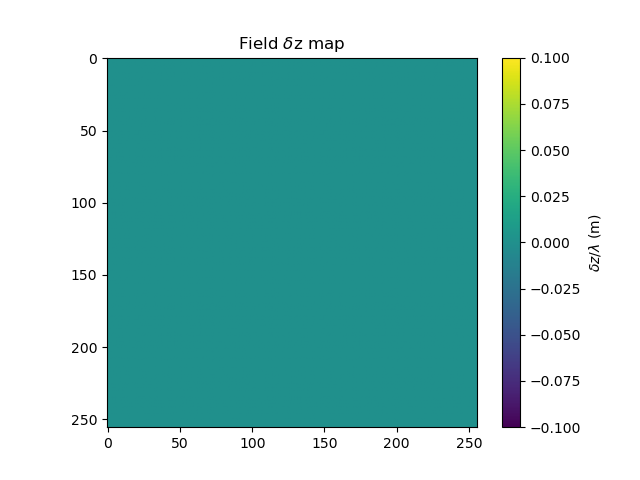

In [302]:
# define the source plane path difference: essentially, the shape of the incident surface relative to the source plane
dz = np.zeros((N, N))

# a tilt
n_lambd = 0
for j in range(dz.shape[1]):
    dz[:, j] += -n_lambd * lambd / 2.  + n_lambd * (lambd / width_m) * (j * m_per_px )

# a parabolic dish
# a = 8e2
# b = a
# for i in range(dz.shape[0]):
#     for j in range(dz.shape[1]):
#         dz[i][j] -= ((i * m_per_px) - (width_m / 2.)) ** 2. / (a ** 2.) + ((j * m_per_px) - (height_m / 2.)) ** 2. / (b ** 2.)

# a sphere
# for i in range(dz.shape[0]):
#     for j in range(dz.shape[1]):
#         x2 = ((i * m_per_px) - (width_m / 2.)) ** 2.
#         y2 = ((j * m_per_px) - (height_m / 2.)) ** 2.
#         r2 = (z) ** 2.
#         dz[i][j] += np.sqrt(r2 - x2 - y2) - z

# a step
# for i in range(dz.shape[0]):
#     for j in range(dz.shape[1]):
#         if j < dz.shape[1] // 2:
#             dz[i][j] += (1e4 * lambd) + lambd / 4.
#         else:
#             dz[i][j] += -(1e4 * lambd) - lambd / 4.

fig, ax = plt.subplots()
im = ax.imshow(dz / lambd)
ax.set_title('Field $\delta$z map')
fig.colorbar(im, ax=ax, label='$\delta z / \lambda$ (m)')

In [303]:
@njit(parallel=True)
def fresnel_kernel(img, m_per_px, x, y, z, lambd):
    A = 1. / (1j * lambd)
    k = 2. * np.pi / lambd
    res = np.zeros((img.shape[0], img.shape[1]), dtype=np.complex64)
    for i in prange(img.shape[0]):
        for j in prange(img.shape[1]):
            xp = i * m_per_px
            yp = j * m_per_px
            r = np.sqrt((x - xp) ** 2. + (y - yp) ** 2. + (z) ** 2.)
            res[i][j] = img[i][j] * np.exp(1j * k * r) * z / r ** 2.

    return res.flatten().sum()

In [304]:
# Calculate the diffraction pattern some distance away
@njit(parallel=True)
def E_fresnel(img, z, dz):
    A = 1. / (1j * lambd)
    k = 2. * np.pi / lambd
    e_fresnel = np.zeros_like(img, dtype=np.complex64)
    # for each pixel in the field
    for i in prange(img.shape[0]):
        for j in prange(img.shape[1]):
            x = i * m_per_px
            y = j * m_per_px
            # perform the fresnel integral over all source-field pairs
            res = np.zeros((img.shape[0], img.shape[1]), dtype=np.complex64)
            for ii in prange(img.shape[0]):
                for jj in prange(img.shape[1]):
                    xp = ii * m_per_px
                    yp = jj * m_per_px
                    r2 = (x - xp) ** 2. + (y - yp) ** 2. + (z + dz[i][j]) ** 2.
                    r = r2 ** .5
                    res[ii][jj] = img[ii][jj] * np.exp(1j * k * r) * (z + dz[i][j]) / r2
            e_fresnel[i][j] = res.flatten().sum() * (m_per_px ** 2.) # Riemann sum: \sum f(x,y) * dx * dy
    return A * e_fresnel

In [305]:
fresnel_img = E_fresnel(img, z, dz)

first null angle 3.05e-05 first null offset 0.01525000000472877


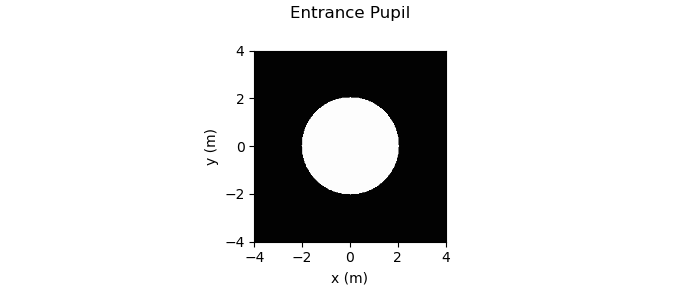

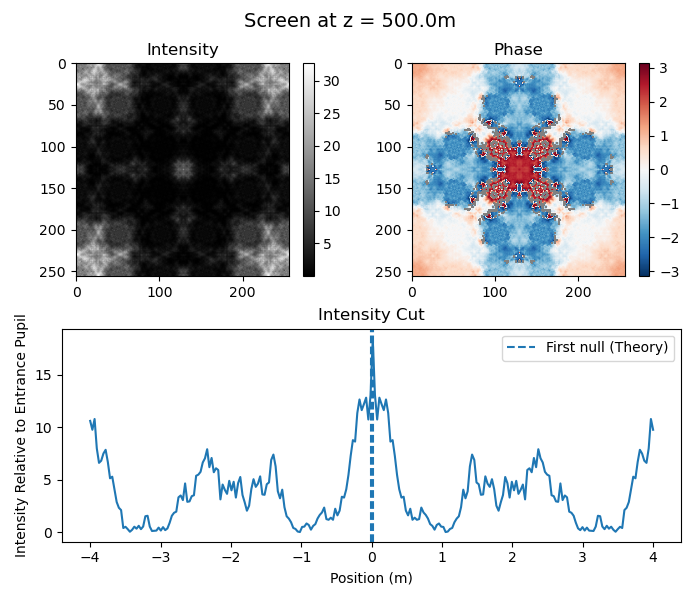

In [306]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)

fig, ax = plt.subplots(figsize=figsize)
ax.contourf(xx, yy, img, levels=50, vmin=0, vmax=1, cmap='gray')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect('equal')
fig.suptitle('Entrance Pupil')
fig.tight_layout()

intensity = (np.abs(fresnel_img) ** 2.)
mean_intens = np.mean(intensity[intensity != 0])
phase = np.angle(fresnel_img)
phase[intensity < mean_intens / 100.] = np.nan
amp = np.sqrt(intensity)

fig = plt.figure(figsize=(7,6), tight_layout=True)
ax0 = fig.add_subplot(gs[0, 0])
im0 = ax0.imshow(intensity, cmap='gray')
fig.colorbar(im0, ax=ax0)
ax0.set_title('Intensity')
ax0.set_aspect('equal')

ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.imshow(phase, cmap='RdBu_r', vmin=-np.pi, vmax=np.pi)
fig.colorbar(im1, ax=ax1)
ax1.set_facecolor('gray')
ax1.set_title('Phase')
ax1.set_aspect('equal')
plt.suptitle("Screen at z = {}m".format(z), fontsize=14)

# loc of first null
thet = 1.22 * (lambd) / (2. * radius_m)
first_null = np.tan(thet) * z
print('first null angle', thet, 'first null offset', first_null)

ax2 = fig.add_subplot(gs[1,:])
ax2.plot(xs, intensity[intensity.shape[0] // 2, :])
ax2.set_xlabel('Position (m)')
ax2.set_ylabel('Intensity Relative to Entrance Pupil')
ax2.axvline(first_null, linestyle='--', label='First null (Theory)')
ax2.axvline(-first_null, linestyle='--')
ax2.set_title('Intensity Cut')
ax2.legend(loc='best')

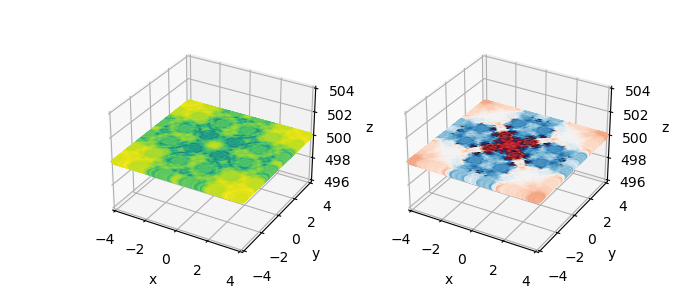

In [307]:
from mpl_toolkits import mplot3d

fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2, subplot_kw={'projection':'3d'})
ax[0].set_xlim(xs.min(), xs.max())
ax[0].set_ylim(ys.min(), ys.max())
ax[0].set_zlim((z + ys).min(), (z + ys).max())
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_zlabel('z')
stride = 1
ax[0].scatter(
    xx[::stride,::stride],
    yy[::stride,::stride],
    z + dz[::stride,::stride],
    c=np.log10(intensity[::stride,::stride]),
    edgecolor='none',
    alpha=0.9
)

ax[1].set_xlim(xs.min(), xs.max())
ax[1].set_ylim(ys.min(), ys.max())
ax[1].set_zlim((z + ys).min(), (z + ys).max())
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_zlabel('z')
ax[1].scatter(
    xx[::stride,::stride],
    yy[::stride,::stride],
    z + dz[::stride,::stride],
    c=phase[::stride,::stride],
    edgecolor='none',
    cmap='RdBu_r',
    alpha=0.9
)

## Compare quantitatively to POPPY Fresnel simulation with same parameters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


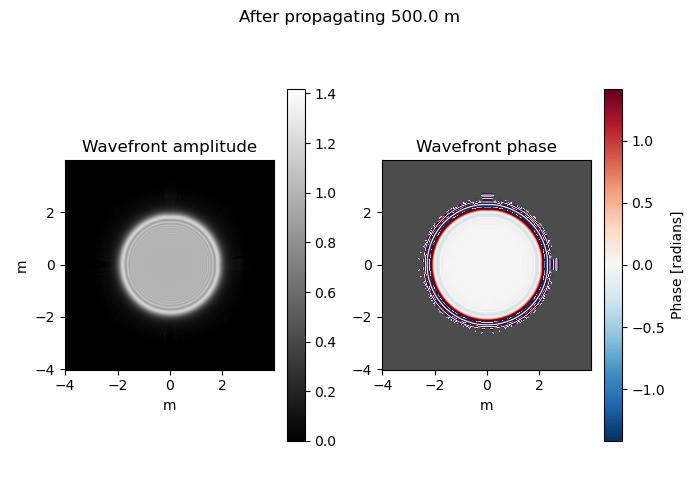

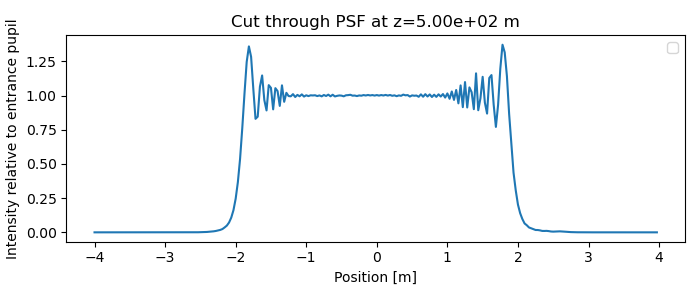

In [308]:
oversample = 2
npix = N // oversample # ~512 is minimum to accurately recover the central diffraction spike
wf = poppy.FresnelWavefront(radius_m*u.m,wavelength=lambd,npix=npix,oversample=oversample)
wf *= poppy.CircularAperture(radius=radius_m) 

fig = plt.figure(figsize=(7,5), tight_layout=True)

wf.display('both', colorbar=True, showpadding=True)
plt.suptitle("Entrance Pupil", fontsize=12)
plt.tight_layout()

z_poppy = z*u.m
wf.propagate_fresnel(z_poppy)

wf.display('both', colorbar=True)
plt.suptitle("After propagating {}".format(z_poppy), fontsize=12)
plt.tight_layout()

plt.figure(figsize=figsize)
y, x = wf.coordinates()
plt.plot(x[wf.intensity.shape[1]//2,:], wf.intensity[wf.intensity.shape[1]//2,:])
plt.title("Cut through PSF at z={:0.2e}".format(z_poppy))
plt.xlabel('Position [m]')
plt.ylabel('Intensity relative to entrance pupil')
plt.tight_layout()

# plt.plot([0], [3.30], 'o', label='Theory')
plt.legend(loc='upper right')

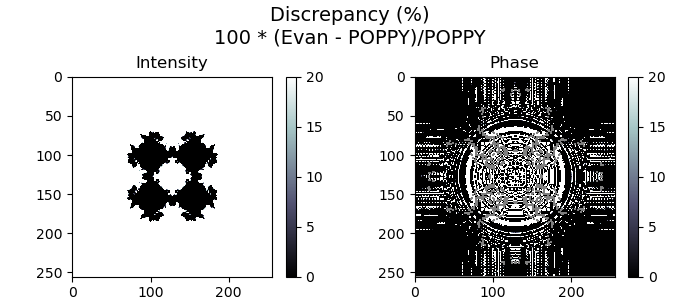

In [309]:
fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2)

im0 = ax[0].imshow(100. * (intensity - wf.intensity) / wf.intensity, cmap='bone', vmin=0, vmax=20)
# im0 = ax[0].imshow((intensity - wf.intensity), cmap='bone')#, vmin=0, vmax=5)
fig.colorbar(im0, ax=ax[0])
ax[0].set_title('Intensity')
ax[0].set_aspect('equal')

im1 = ax[1].imshow(100. * (phase - wf.phase) / wf.phase, cmap='bone', vmin=0, vmax=20)
# im1 = ax[1].imshow((phase - wf.phase), cmap='bone')#, vmin=0, vmax=5)
fig.colorbar(im1, ax=ax[1])
ax[1].set_title('Phase')
ax[1].set_facecolor('gray')
ax[1].set_aspect('equal')

plt.suptitle('Discrepancy (%)\n100 * (Evan - POPPY)/POPPY', fontsize=14)
fig.tight_layout()